In [21]:
import os
import shutil
from facenet_pytorch import MTCNN
import cv2
import torch
import numpy as np
from deepface import DeepFace
from PIL import Image

# **Image processing**

### **Get path, create, and crop the image with the corresponding person**
Get the path to the images, get the names of the directories (which are the political figures), scanned through all of the images, crop them, and then create a directory to store them

In [22]:
path_to_data = './dataset/'
path_to_images = './dataset/cropped/'

In [25]:
img_dir = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]
img_dir

['./dataset/Vladimir Putin',
 './dataset/Elon Musk',
 './dataset/Donald Trump',
 './dataset/Joe Biden']

In [26]:
os.path.exists(path_to_images)

False

In [27]:
# Load MTCNN face detector
mtcnn = MTCNN(keep_all=True)

In [28]:
## This code is to delete the cropped images folder and create a new one
if os.path.exists(path_to_images):
    shutil.rmtree(path_to_images)
os.makedirs(path_to_images)

In [29]:
# Delete the .DS_Store file
if os.path.exists('./dataset/.DS_Store'):
    os.remove('./dataset/.DS_Store')

In [30]:
# Counter to track faces across all images
face_counters = {}

for person in os.listdir(path_to_data):

    if person == 'cropped':
        continue

    # Initialize counter for this person
    if person not in face_counters:
        face_counters[person] = 0

    # ./dataset/person1
    person_path = os.path.join(path_to_data, person)
    # ./dataset/cropped/person1
    cropped_person_path = os.path.join(path_to_images, person)

    # Skip non-directories
    if not os.path.isdir(person_path):
        continue

    # create a directory for the person
    os.makedirs(cropped_person_path, exist_ok=True)

    print(f"Processing images for {person}")

    for image_name in os.listdir(person_path):

        # Get the path to the image
        image_path = os.path.join(person_path, image_name)

        try:
            # Load and verify image
            img = Image.open(image_path)
            img.verify()  # Check if image is corrupt
            img = Image.open(image_path)  # Reload after verification

            # Detect faces
            boxes, _ = mtcnn.detect(img)

            # If no faces are detected, move on to the next image
            if boxes is not None:
                # loop through all the faces detected
                for i, box in enumerate(boxes):
                    # Get the coordinates of the box
                    x, y, x2, y2 = map(int, box)


                    face = img.crop((x, y, x2, y2))

                    # Create unique name using the incremented counter
                    face_save_name = f"{person}_{face_counters[person]}.jpg"
                    face_save_path = os.path.join(cropped_person_path, face_save_name)

                    # Save the face
                    face.save(face_save_path)
                    print(f"Saved {face_save_path}")

                    # Increment the counter for this person
                    face_counters[person] += 1
            else:
                print(f"No faces detected in {image_path}")

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    print(f"Completed {person}. Total faces saved: {face_counters[person]}")

print("Face detection done")

Processing images for Vladimir Putin
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_0.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_1.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_2.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_3.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_4.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_5.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_6.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_7.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_8.jpg
Error processing ./dataset/Vladimir Putin/.DS_Store: cannot identify image file './dataset/Vladimir Putin/.DS_Store'
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_9.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_10.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_11.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_12.jpg
Saved ./dataset/cropped/Vladimir Putin/Vladimir Putin_13.jpg
Sa

In [31]:
# Print total images cropped for each person
for person, count in face_counters.items():
    print(f"{person}: {count} images")

Vladimir Putin: 87 images
Elon Musk: 108 images
Donald Trump: 131 images
Joe Biden: 120 images


# **Data preprocessing**

In [32]:
# Remove the .DS_Store file
if os.path.exists('./dataset/cropped/.DS_Store'):
    os.remove('./dataset/cropped/.DS_Store')

In [33]:
people = sorted(os.listdir(path_to_images))
people

['Donald Trump', 'Elon Musk', 'Joe Biden', 'Vladimir Putin']

In [34]:
label_dict = {name : i for i, name in enumerate(people)}
print("Label dictionary:", label_dict)

Label dictionary: {'Donald Trump': 0, 'Elon Musk': 1, 'Joe Biden': 2, 'Vladimir Putin': 3}


In [42]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simpler transformations for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [44]:
# Custom Dataset class that works with your cropped face images
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get list of people (classes) - these are the subdirectories in the cropped folder
        self.people = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.people.sort()  # Sort to ensure consistent ordering
        self.label_dict = {name: i for i, name in enumerate(self.people)}

        print(f"Found {len(self.people)} classes: {self.people}")

        # Load all image paths and labels
        for person in self.people:
            person_dir = os.path.join(root_dir, person)
            if os.path.isdir(person_dir):
                for img_name in os.listdir(person_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(person_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(self.label_dict[person])

        print(f"Loaded {len(self.image_paths)} images in total")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [45]:
# Create two separate datasets with their respective transforms
train_face_dataset = FaceDataset(path_to_images, transform=train_transform)
val_face_dataset = FaceDataset(path_to_images, transform=val_transform)

Found 4 classes: ['Donald Trump', 'Elon Musk', 'Joe Biden', 'Vladimir Putin']
Loaded 446 images in total
Found 4 classes: ['Donald Trump', 'Elon Musk', 'Joe Biden', 'Vladimir Putin']
Loaded 446 images in total


# **Model training**

In [40]:
# Create indices for train/val split (70/30)
dataset_size = len(train_face_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_size = int(0.8 * dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

In [46]:
# Create a subset sampler for training and validation
from torch.utils.data import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [47]:
# Create DataLoaders for training and validation
train_loader = DataLoader(train_face_dataset, batch_size=8, sampler=train_sampler, num_workers=0)
val_loader = DataLoader(val_face_dataset, batch_size=8, sampler=val_sampler, num_workers=0)

### **Select the model for the training**

In [48]:
import torch.nn as nn
import torchvision.models as models

# Load the pretrained ResNet model
model = models.resnet18(pretrained=True)

In [49]:
# Modify the final fully connected layer with dropout for regularization

num_classes = len(train_face_dataset.people)
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, num_classes)
)

In [53]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 0.001},        # Highest learning rate for classification layer
    {'params': model.layer4.parameters(), 'lr': 0.0005},   # Higher learning rate for later features
    {'params': model.layer3.parameters(), 'lr': 0.0003},   # Medium learning rate for mid-level features
    {'params': model.layer2.parameters(), 'lr': 0.0001},   # Lower learning rate for earlier features
    {'params': model.layer1.parameters(), 'lr': 0.00005},  # Very low learning rate for basic features
    {'params': model.conv1.parameters(), 'lr': 0.00001}    # Minimal learning rate for initial layers
], weight_decay=1e-4)

In [56]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

In [57]:
from sklearn.metrics import accuracy_score

# Training loop
num_epochs = 25
best_loss = float('inf')
best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []

print("Starting training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.inference_mode():
        for images, labels in val_loader:

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions and probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Calculate validation accuracy
    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    # Update learning rate based on validation loss
    scheduler.step(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = epoch_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f"Saved new best model with validation accuracy: {val_acc:.4f}")
print("Training complete!")

Starting training...
Epoch 1/25, Train Loss: 0.9427, Val Loss: 0.2708, Val Acc: 0.9111, LR: 0.001000
Saved new best model with validation accuracy: 0.9111
Epoch 2/25, Train Loss: 0.5474, Val Loss: 0.3481, Val Acc: 0.8556, LR: 0.001000
Epoch 3/25, Train Loss: 0.3800, Val Loss: 0.4010, Val Acc: 0.8444, LR: 0.001000
Epoch 4/25, Train Loss: 0.2799, Val Loss: 0.2116, Val Acc: 0.9222, LR: 0.001000
Saved new best model with validation accuracy: 0.9222
Epoch 5/25, Train Loss: 0.3135, Val Loss: 0.2704, Val Acc: 0.8889, LR: 0.001000
Epoch 6/25, Train Loss: 0.2677, Val Loss: 0.1420, Val Acc: 0.9556, LR: 0.001000
Saved new best model with validation accuracy: 0.9556
Epoch 7/25, Train Loss: 0.2041, Val Loss: 0.1523, Val Acc: 0.9333, LR: 0.001000
Epoch 8/25, Train Loss: 0.2144, Val Loss: 0.2195, Val Acc: 0.9111, LR: 0.001000
Epoch 9/25, Train Loss: 0.2116, Val Loss: 0.1534, Val Acc: 0.9222, LR: 0.000200
Epoch 10/25, Train Loss: 0.1943, Val Loss: 0.1229, Val Acc: 0.9333, LR: 0.000200
Epoch 11/25, Tra

### **Testing the model**

In [58]:
# Load the best model for evaluation
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.4f}")

Loaded best model from epoch 6 with validation accuracy: 0.9556


In [59]:
# Final evaluation on validation set
model.eval()
all_preds = []
all_labels = []
all_probs = []
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        # Calculate per-class accuracy
        correct = (preds == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

In [60]:
from sklearn.metrics import confusion_matrix

# Calculate final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

In [61]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

In [62]:
print(f"Final validation accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Final validation accuracy: 0.9556
Precision: 0.9624
Recall: 0.9556
F1 Score: 0.9567


In [63]:
# pre-accuracy report
print("Accuracy report:")
for i in range(num_classes):
    print(f"{train_face_dataset.people[i]}: {class_correct[i] * 100 / class_total[i]:.4f}")

Accuracy report:
Donald Trump: 93.3333
Elon Musk: 95.4545
Joe Biden: 100.0000
Vladimir Putin: 93.7500


In [65]:
from sklearn.metrics import classification_report

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_face_dataset.people))


Classification Report:
                precision    recall  f1-score   support

  Donald Trump       1.00      0.93      0.97        30
     Elon Musk       1.00      0.95      0.98        22
     Joe Biden       0.85      1.00      0.92        22
Vladimir Putin       1.00      0.94      0.97        16

      accuracy                           0.96        90
     macro avg       0.96      0.96      0.96        90
  weighted avg       0.96      0.96      0.96        90



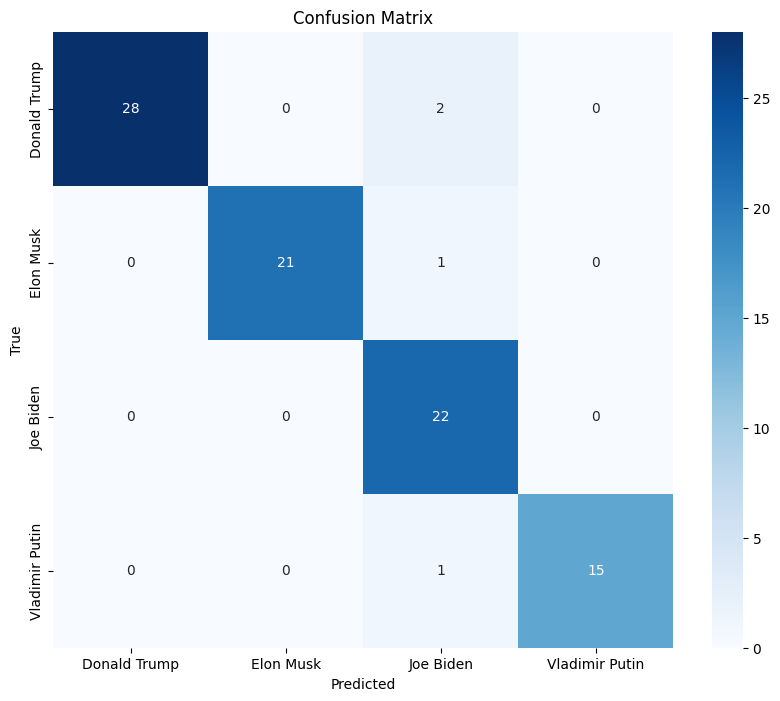

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_face_dataset.people,
            yticklabels=train_face_dataset.people)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


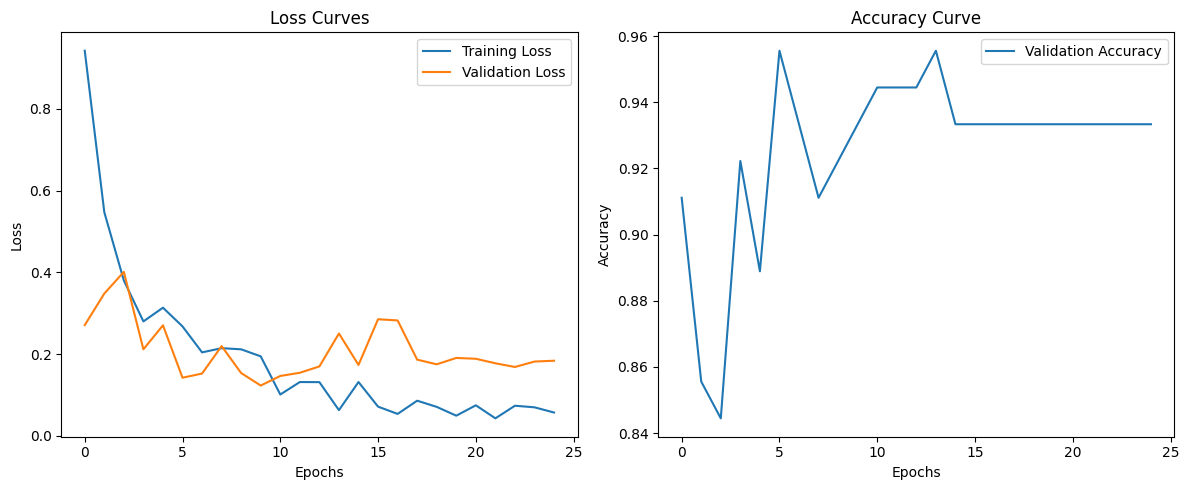

In [69]:
# Plot training and validation curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
